<a href="https://colab.research.google.com/github/Pravallika41296/IANNWTF_Homework_Group24/blob/main/IANNWTF_Homework06_Group24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all the necessary packages
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import time

In [2]:
#Loading the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:

batch_size = 64

# Creates tensorflow datasets for the training and test data.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
train_dataset = train_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tar, 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tar, 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)


In [4]:
#Checking the dimensions of the 
for (img,label) in train_dataset:
    print(label.shape)# the first dimension is the batch size / number of inputs
    break;

(64, 1, 10)


In [37]:
class ResidualBlock(tf.keras.layers.Layer):
  
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters=channels, kernel_size=1, padding='SAME', activation='relu',
                                        input_shape=(32,32,3))
    self.bn1 =  tf.keras.layers.BatchNormalization()
           
    self.conv2 = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding='SAME',activation='relu')
    self.bn2 =  tf.keras.layers.BatchNormalization()

    self.conv3 = tf.keras.layers.Conv2D(filters=channels, kernel_size=1, padding='SAME', activation='relu')
    self.bn3 =  tf.keras.layers.BatchNormalization()

  @tf.function
  def call(self, x, training):

    # define call
    # add original input to block output
    y = self.conv1(x)
    y = self.bn1(y, training = training)
    y = self.conv2(y)
    y = self.bn2(y, training = training)
    y = self.conv3(y)
    y = self.bn3(y, training = training)

    y = y + x
    return y


In [41]:
class ResNet(tf.keras.Model):

  def __init__(self, num_blocks=8, channels_in_block=3):

    super(ResNet, self).__init__()

    # you can define a set of layes to put in front of the Residual blocks
    self.pre_block = [tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=3, padding='SAME', activation= "relu")]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=3, padding='SAME', activation= "relu"))
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=3, padding='SAME', activation= "relu"))
    self.pre_block.append(tf.keras.layers.BatchNormalization())

    # now you can use your self defined blocks much like layers
    self.blocks = []
    for _ in range(num_blocks):
        self.blocks.append(ResidualBlock(channels=channels_in_block))

    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_blocks.append(tf.keras.layers.Dense(units=10, activation = "softmax"))

  @tf.function
  def call(self, x, training_flag):
      # pass input through pre_block layers
      # you can pass the training flag to every layer in tf
    for layer in self.pre_block:
      x = layer(x, training=training_flag)     
    y = x
    for b in self.blocks:
      y = b(y)
     # readout layers
    for b in self.post_blocks:
      y = b(y)
    # make sure prediction and target dimension match
    y = tf.expand_dims(y, axis=1)
    return y

In [8]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same', activation = 'relu')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x, training):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y, training = training)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y

In [9]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

In [10]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x, training):
        x = self.batch_norm(x, training = training)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

In [20]:
class DenseNet(tf.keras.Model):
  def __init__(self, channels_in_block=3):
    super(DenseNet, self).__init__()

    # you can define a set of layes to put in front of the Residual blocks
    self.pre_block = [tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=3, padding='SAME')]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.blocks = []
    num_channels, growth_rate = 3 , 32
    num_convs_in_dense_blocks = [4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        self.blocks.append((DenseBlock(num_convs, growth_rate)))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that haves the number of channels is added
        # between the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            self.blocks.append((TransitionBlock(num_channels)))

    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_blocks.append(tf.keras.layers.Dense(units=10, activation = "softmax"))
    # now you can use your self defined blocks much like layers

  @tf.function
  def call(self, x, training_flag):
      # pass input through pre_block layers
      # you can pass the training flag to every layer in tf
    for layer in self.pre_block:
      x = layer(x, training=training_flag)     
    y = x
    for b in self.blocks:
      y = b(y)
     # readout layers
    for b in self.post_blocks:
      y = b(y)
    # make sure prediction and target dimension match
    y = tf.expand_dims(y, axis=1)
    return y

In [12]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

In [25]:
#Function for the accuracy measure 
def acc_metric(target,output):
    acc = np.argmax(target, axis=2) == np.argmax(output, axis=2) 
    acc = np.mean(acc)
    return acc

In [14]:
#Defining the training and testing functions
def train_step(model, input, target, loss_function, optimizer, training = True):

  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(target, prediction) 
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training =False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  acc_metric(target, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
ResNetmodel = ResNet()
DenseNetmodel = DenseNet()
# Initialize the loss: categorical cross entropy
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
Rtrain_losses = []
Dtrain_losses = []
Rtest_losses = []
Rtest_accuracies = []
Dtest_losses = []
Dtest_accuracies = []

#testing once before we begin
#test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
#train_loss, _ = test(model, train_dataset, cross_entropy_loss)
#train_losses.append(train_loss)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    Raverage = []
    start = time.time()
    for (image,target) in train_dataset:
      Rtrain_loss = train_step(ResNetmodel, image , target, cross_entropy_loss, optimizer)
      Raverage.append(Rtrain_loss)   

    print(f"ResNet :The training step took {timing(start)} seconds")       
    Rtrain_losses.append(np.mean(Raverage))

     #testing
    Rtest_loss, Rtest_accuracy = test(ResNetmodel, train_dataset, cross_entropy_loss)
    Rtest_losses.append(Rtest_loss)
    Rtest_accuracies.append(Rtest_accuracy)
    print('ResNet: Test Accuracy: ', Rtest_accuracy)
    print('ResNet: Test Loss: ', Rtest_losses)

for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    Daverage = []
    Dstart = time.time()
    for (image,target) in train_dataset:
        Dtrain_loss = train_step(DenseNetmodel, image , target, cross_entropy_loss, optimizer)
        Daverage.append(Dtrain_loss)   

    print(f" DenseNet :The training step took {timing(Dstart)} seconds")       
    Dtrain_losses.append(np.mean(Daverage))
      
    
    #testing
    Dtest_loss, Dtest_accuracy = test(DenseNetmodel, test_dataset, cross_entropy_loss)
    Dtest_losses.append(Dtest_loss)
    Dtest_accuracies.append(Dtest_accuracy)
    print(' DenseNet: Test Accuracy: ', Dtest_accuracy)
    print(' DenseNet: Test loss: ', Dtest_losses)


In [ ]:
ResNetmodel.summary()
DenseNetmodel.summary()

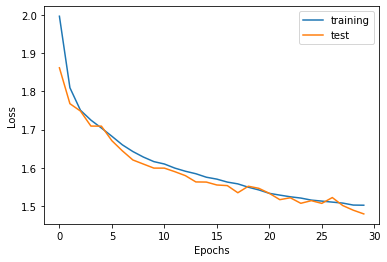

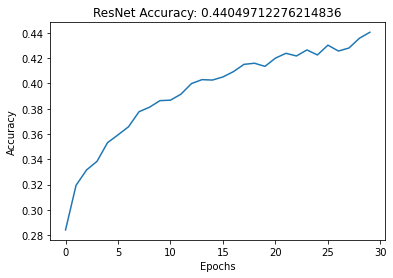

In [45]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(Rtrain_losses)
line2, = plt.plot(Rtest_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(Rtest_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet Accuracy: " + str(Rtest_accuracies[-1]))
plt.show()

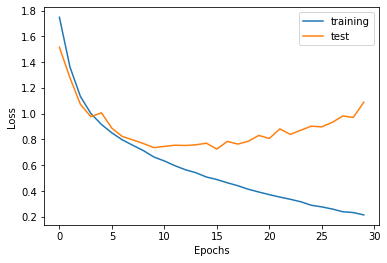

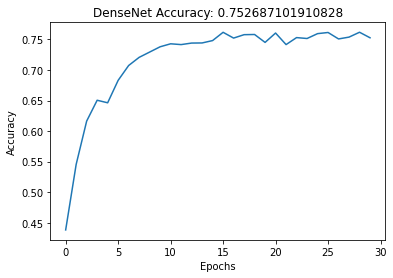

In [46]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(Dtrain_losses)
line2, = plt.plot(Dtest_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(Dtest_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("DenseNet Accuracy: " + str(Dtest_accuracies[-1]))
plt.show()